<a href="https://colab.research.google.com/github/RewinaB/Deep-Learning-Projects/blob/main/Hiring_time_and__cost_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time to Hire and Cost per Hire Modeling

This notebook simulates realistic hiring data and builds regression models to predict:
- `Time to Hire`
- `Cost per Hire`

We then analyze key drivers and recommend optimizations for resource allocation.

In [1]:

import numpy as np
import pandas as pd

np.random.seed(42)
n = 5000

roles = ['Engineer', 'Manager', 'Sales', 'Support', 'Analyst']
locations = ['NY', 'SF', 'Austin', 'Remote']
channels = ['LinkedIn', 'Referral', 'Agency', 'Internal', 'JobFair']
recruiters = ['Alice', 'Bob', 'Charlie', 'Diana']
job_levels = ['Junior', 'Mid', 'Senior']

df = pd.DataFrame({
    'role': np.random.choice(roles, size=n),
    'location': np.random.choice(locations, size=n),
    'sourcing_channel': np.random.choice(channels, size=n, p=[0.3, 0.25, 0.15, 0.2, 0.1]),
    'recruiter': np.random.choice(recruiters, size=n),
    'candidate_experience': np.round(np.random.normal(5, 2, size=n), 1),
    'job_level': np.random.choice(job_levels, size=n),
    'team_size': np.random.randint(3, 20, size=n)
})

df['candidate_experience'] = df['candidate_experience'].clip(0.5, 15)

# Simulate time_to_hire and cost_per_hire
df['time_to_hire'] = (
    30
    - (df['candidate_experience'] * 0.5)
    - df['team_size'] * 0.1
    + df['role'].map({'Engineer': 2, 'Manager': 4, 'Sales': 1, 'Support': 1, 'Analyst': 3})
    + df['sourcing_channel'].map({'Referral': -3, 'LinkedIn': -1, 'Agency': 2, 'Internal': -2, 'JobFair': 1})
    + np.random.normal(0, 2, size=n)
).round(1)

df['cost_per_hire'] = (
    3000
    + (df['time_to_hire'] * 25)
    + df['role'].map({'Engineer': 500, 'Manager': 1000, 'Sales': 400, 'Support': 300, 'Analyst': 600})
    + df['sourcing_channel'].map({'Referral': 200, 'LinkedIn': 300, 'Agency': 800, 'Internal': 100, 'JobFair': 400})
    + np.random.normal(0, 300, size=n)
).round(2)

df.to_csv("simulated_hiring_data.csv", index=False)
df.head()


,role,location,sourcing_channel,recruiter,candidate_experience,job_level,team_size,time_to_hire,cost_per_hire
0,Support,SF,Agency,Alice,5.3,Mid,12,33.2,5296.09
1,Analyst,Austin,LinkedIn,Alice,3.5,Mid,11,29.7,4515.80
2,Sales,Remote,Referral,Charlie,4.0,Mid,3,24.9,4467.99
3,Analyst,SF,LinkedIn,Alice,2.7,Junior,5,29.6,4270.76
4,Analyst,SF,JobFair,Bob,4.6,Senior,15,29.2,4644.65


In [5]:
#  1. DESCRIPTIVE ANALYSIS

# Summary statistics for time_to_hire and cost_per_hire
summary_stats = df[['time_to_hire', 'cost_per_hire']].describe()

# Groupby Aggregations
grouped_by_channel = df.groupby("sourcing_channel")[["time_to_hire", "cost_per_hire"]].mean().sort_values(by="time_to_hire")
grouped_by_role = df.groupby("role")[["time_to_hire", "cost_per_hire"]].mean().sort_values(by="time_to_hire")
grouped_by_location = df.groupby("location")[["time_to_hire", "cost_per_hire"]].mean().sort_values(by="time_to_hire")
grouped_by_recruiter = df.groupby("recruiter")[["time_to_hire", "cost_per_hire"]].mean().sort_values(by="time_to_hire")


print(grouped_by_channel)
print(grouped_by_role)
print(grouped_by_location)
print(grouped_by_recruiter)


                  time_to_hire  cost_per_hire
sourcing_channel                             
Referral             25.564528    4392.797162
Internal             26.507018    4321.256254
LinkedIn             27.569108    4533.662996
JobFair              29.613053    4692.346379
Agency               30.576406    5114.694664
          time_to_hire  cost_per_hire
role                                 
Sales        26.241099    4360.589888
Support      26.440337    4279.948781
Engineer     27.220707    4492.686438
Analyst      28.172168    4606.153125
Manager      29.289119    5051.933523
          time_to_hire  cost_per_hire
location                             
SF           27.432670    4553.139319
Austin       27.453045    4557.027756
NY           27.466366    4548.309967
Remote       27.509054    4561.401900
           time_to_hire  cost_per_hire
recruiter                             
Charlie       27.413047    4546.271114
Alice         27.428457    4549.959108
Bob           27.463245    4

Below we will do Outlier detection
It filters rows where the absolute Z-score is greater than 3, meaning:

These hires took much longer or shorter than normal.

Or they were much more or less expensive than typical.

In [7]:
# Outlier detection: Z-score method
from scipy.stats import zscore
df['z_time'] = zscore(df['time_to_hire'])
df['z_cost'] = zscore(df['cost_per_hire'])
outliers_time = df[df['z_time'].abs() > 3]
outliers_cost = df[df['z_cost'].abs() > 3]

print (outliers_time)
print (outliers_cost)

         role location sourcing_channel recruiter  candidate_experience  \
30      Sales       SF         LinkedIn     Diana                   7.9   
549   Manager       NY           Agency     Alice                   3.1   
1602  Manager   Austin           Agency       Bob                   2.1   
1919  Support       SF         Referral     Diana                   6.6   
2028    Sales   Austin         Referral       Bob                   9.8   
2147  Analyst       SF         Referral   Charlie                   9.9   
3024  Analyst   Austin           Agency     Diana                   3.3   
3049  Analyst       SF           Agency     Alice                   2.5   
3851  Manager       SF           Agency     Alice                   3.9   
4051  Manager       NY           Agency   Charlie                   0.7   
4239  Analyst   Austin           Agency   Charlie                   0.6   

     job_level  team_size  time_to_hire  cost_per_hire    z_time    z_cost  
30         Mid        

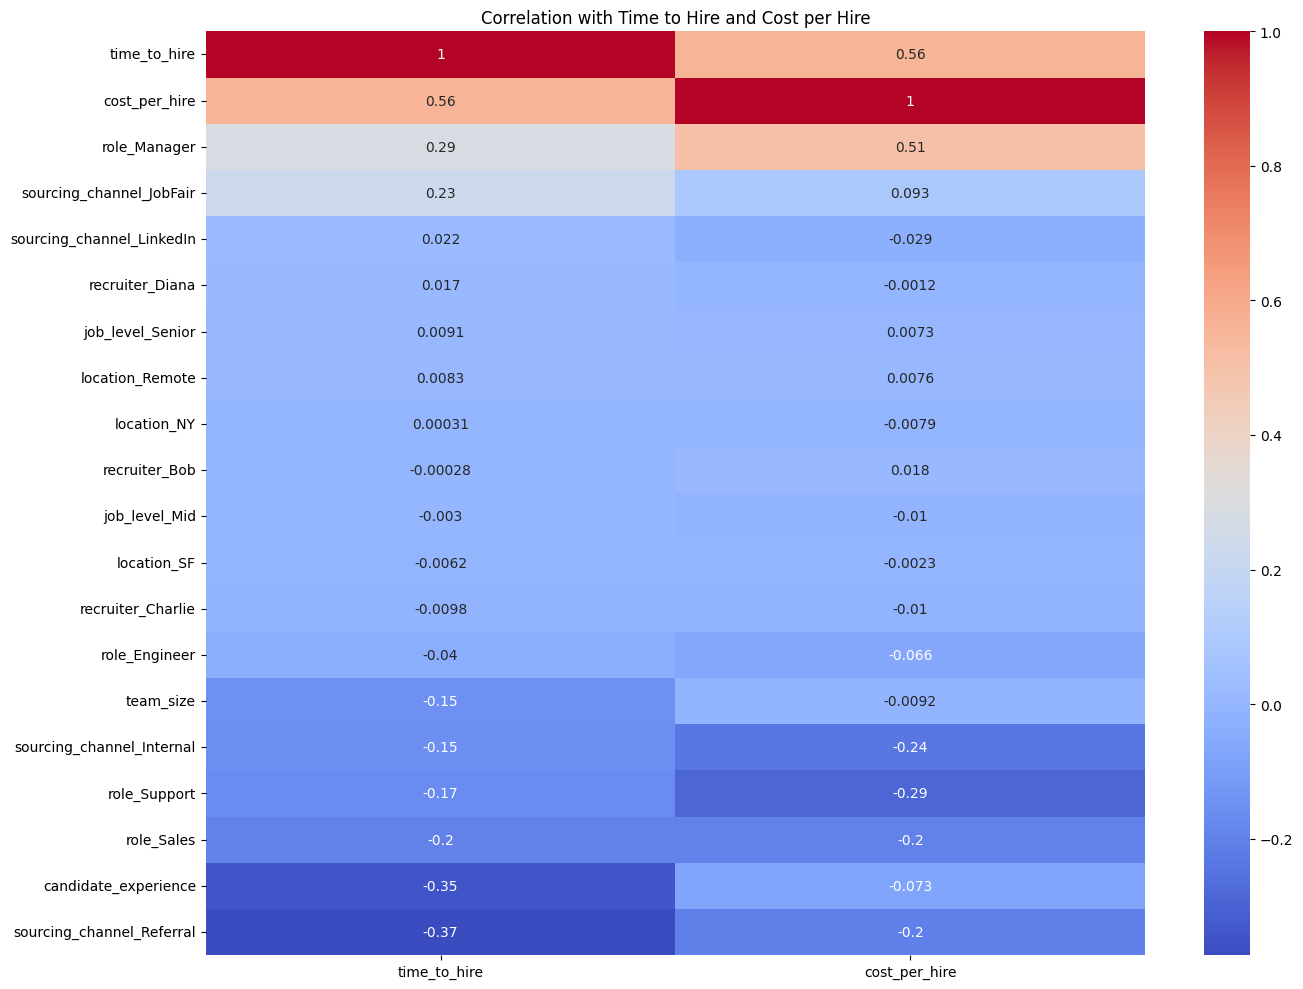

In [10]:
#  2. CORRELATION ANALYSIS

# Encode categorical columns for correlation
df_encoded = pd.get_dummies(df.drop(columns=['z_time', 'z_cost']), drop_first=True)
correlation_matrix = df_encoded.corr()

# Extract correlations with target variables
corr_with_time = correlation_matrix['time_to_hire'].sort_values(ascending=False)
corr_with_cost = correlation_matrix['cost_per_hire'].sort_values(ascending=False)

# Plot heatmap for the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix[['time_to_hire', 'cost_per_hire']].sort_values(by='time_to_hire', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with Time to Hire and Cost per Hire")
plt.tight_layout()
plt.show()

In [17]:
print(X.columns)


Index(['role', 'location', 'sourcing_channel', 'recruiter',
       'candidate_experience', 'job_level', 'team_size', 'z_time', 'z_cost'],
      dtype='object')


In [18]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

X = X = df.drop(columns=['time_to_hire', 'cost_per_hire', 'z_time', 'z_cost'])
y_time = df['time_to_hire']
y_cost = df['cost_per_hire']

cat_features = ['role', 'location', 'sourcing_channel', 'recruiter', 'job_level']
num_features = ['candidate_experience', 'team_size']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), cat_features)
], remainder='passthrough')

X_train, X_test, y_train_time, y_test_time = train_test_split(X, y_time, test_size=0.2, random_state=42)
_, _, y_train_cost, y_test_cost = train_test_split(X, y_cost, test_size=0.2, random_state=42)


In [19]:
print("\nModel: Linear Regression on Time to Hire")
model = LinearRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
pipeline.fit(X_train, y_train_time)
preds = pipeline.predict(X_test)
mse = mean_squared_error(y_test_time, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_time, preds)

print("RMSE:", rmse)
print("R² Score:", r2)


Model: Linear Regression on Time to Hire
RMSE: 1.9011755630045755
R² Score: 0.6056252092229115


In [22]:

print("\nModel: Random Forest on Time to Hire")
model = RandomForestRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
pipeline.fit(X_train, y_train_time)
preds = pipeline.predict(X_test)
mse = mean_squared_error(y_test_time, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_time, preds)
print("RMSE:", rmse)
print("R² Score:", r2)



Model: Random Forest on Time to Hire
RMSE: 2.083225466563845
R² Score: 0.5264811727452023


In [23]:

print("\nModel: XGBoost on Time to Hire")
model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
pipeline.fit(X_train, y_train_time)
preds = pipeline.predict(X_test)
mse = mean_squared_error(y_test_time, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_time, preds)
print("RMSE:", rmse)
print("R2:", r2)



Model: XGBoost on Time to Hire
RMSE: 2.1455977803640627
R2: 0.4977021469932924


In [24]:

print("\nModel: Linear Regression on Cost per Hire")
model = LinearRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
pipeline.fit(X_train, y_train_cost)
preds = pipeline.predict(X_test)
mse = mean_squared_error(y_test_cost, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cost, preds)
print("RMSE:", rmse)
print("R2:", r2)



Model: Linear Regression on Cost per Hire
RMSE: 300.5794538572012
R2: 0.6098059791865039


In [25]:

print("\nModel: Random Forest on Cost per Hire")
model = RandomForestRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
pipeline.fit(X_train, y_train_cost)
preds = pipeline.predict(X_test)
mse = mean_squared_error(y_test_cost, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cost, preds)
print("RMSE:", rmse)
print("R2:", r2)



Model: Random Forest on Cost per Hire
RMSE: 329.3877320601864
R2: 0.5314274230538583


In [26]:

print("\nModel: XGBoost on Cost per Hire")
model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
pipeline.fit(X_train, y_train_cost)
preds = pipeline.predict(X_test)
mse = mean_squared_error(y_test_cost, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cost, preds)
print("RMSE:", rmse)
print("R2:", r2)



Model: XGBoost on Cost per Hire
RMSE: 336.6857880833217
R2: 0.5104336069073739


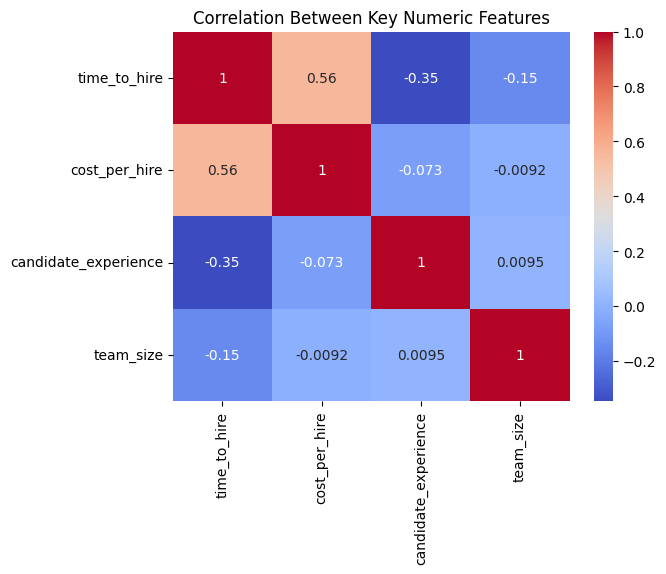

In [27]:

corr_df = df[['time_to_hire', 'cost_per_hire', 'candidate_experience', 'team_size']]
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Key Numeric Features")
plt.show()


**Assessing Feature Impact**

Since linear regression showed a relatively higher R² for both cost per hire and time to hire, we can now use model interpretability techniques to identify which features most influence these outcomes. That will help us make data-driven resource allocation decisions.

* 1. Standardize features: to compare relative importance of features in a linear model

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define categorical and numerical features (assuming these are the same as in previous cells)
cat_features = ['role', 'location', 'sourcing_channel', 'recruiter', 'job_level']
num_features = ['candidate_experience', 'team_size']

# Create the preprocessor (assuming this is the same as in previous cells)
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), cat_features)
], remainder='passthrough')

# Create a pipeline that first preprocesses and then scales the data
feature_processing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)) # Use with_mean=False for sparse output from OneHotEncoder
])

# Apply the preprocessing and scaling to the training data
X_train_scaled = feature_processing_pipeline.fit_transform(X_train)

# Fit linear model on the scaled training data
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_time)

# Get feature names after one-hot encoding and preprocessing
# This step is a bit more involved as we need to get feature names from the OneHotEncoder
ohe_features = feature_processing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
all_features = list(ohe_features) + num_features # Combine one-hot encoded and numerical feature names

# Display standardized coefficients
coefficients = pd.Series(lr.coef_, index=all_features)
coefficients = coefficients.sort_values(key=abs, ascending=False)
print(coefficients)

sourcing_channel_Referral   -2.175121
sourcing_channel_Internal   -1.542471
sourcing_channel_LinkedIn   -1.352587
candidate_experience        -1.012137
role_Support                -0.736947
role_Sales                  -0.720823
team_size                   -0.477506
role_Manager                 0.422020
role_Engineer               -0.368090
sourcing_channel_JobFair    -0.268233
location_Remote             -0.052407
job_level_Senior             0.041750
recruiter_Diana              0.025286
recruiter_Charlie           -0.019561
location_NY                 -0.016569
recruiter_Bob               -0.005659
location_SF                  0.002209
job_level_Mid                0.002097
dtype: float64


| Feature                     | Std. Coefficient | Interpretation                                                     |
| --------------------------- | ---------------- | ------------------------------------------------------------------ |
| `sourcing_channel_Referral` | -2.18            | **Most influential**. Referrals significantly reduce time to hire. |
| `sourcing_channel_Internal` | -1.54            | Internal hiring also speeds up hiring timelines.                   |
| `sourcing_channel_LinkedIn` | -1.35            | LinkedIn is relatively fast compared to other channels.            |
| `candidate_experience`      | -1.01            | More experienced candidates get hired faster.                      |
| `role_Support`              | -0.74            | Support roles are filled relatively quickly.                       |
| `role_Sales`                | -0.72            | Sales roles too, but slightly slower than support.                 |
| `team_size`                 | -0.48            | Larger teams may fill roles quicker (more resources?).             |
| `role_Manager`              | +0.42            | Management roles **take longer** to fill.                          |
| `role_Engineer`             | -0.37            | Slightly faster, but not as much as support or sales.              |


Prioritize referrals and internal mobility programs — they significantly reduce time to hire.

LinkedIn performs better than JobFairs, but less than referrals/internal.

For managerial roles, expect longer hiring timelines → allocate more recruiter bandwidth.

Candidate experience matters: senior hires move faster through the funnel, perhaps due to clearer resumes or signals.

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import pandas as pd

# Define features
cat_features = ['role', 'location', 'sourcing_channel', 'recruiter', 'job_level']
num_features = ['candidate_experience', 'team_size']

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), cat_features)
], remainder='passthrough')  # Keep numerical features

# Full pipeline: OHE + Scaling
feature_processing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

# Fit-transform on X_train
X_train_scaled = feature_processing_pipeline.fit_transform(X_train)

# Linear regression
lr1 = LinearRegression()
lr1.fit(X_train_scaled, y_train_cost)

# Get feature names
ohe_features = feature_processing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
all_features = list(ohe_features) + num_features

# Coefficients
coefficients = pd.Series(lr1.coef_, index=all_features).sort_values(key=abs, ascending=False)
print(coefficients)

sourcing_channel_Referral   -321.507805
sourcing_channel_Internal   -309.532066
sourcing_channel_LinkedIn   -265.830973
role_Manager                 176.784712
role_Support                -127.004525
sourcing_channel_JobFair    -124.218306
role_Sales                   -89.881684
role_Engineer                -39.156868
candidate_experience         -28.872134
team_size                    -14.046311
location_NY                   -5.370184
recruiter_Bob                  4.353481
job_level_Senior               3.120960
job_level_Mid                 -2.395921
location_Remote               -2.229336
recruiter_Diana                1.794565
location_SF                    0.855839
recruiter_Charlie              0.311720
dtype: float64


| Feature                     | Coefficient | Interpretation                                       |
| --------------------------- | ----------- | ---------------------------------------------------- |
| `sourcing_channel_Referral` | **-321.51** | Hiring through referrals saves \~\$321 per hire.     |
| `sourcing_channel_Internal` | **-309.53** | Internal hires save \~\$309 per hire.                |
| `sourcing_channel_LinkedIn` | **-265.83** | LinkedIn hires are cheaper by \~\$265.               |
| `role_Manager`              | **+176.78** | Hiring managers tends to cost \~\$177 more per hire. |
| `role_Support`              | **-127.00** | Support roles are \~\$127 cheaper.                   |
| `sourcing_channel_JobFair`  | **-124.21** | Job fair hires reduce cost by \~\$124.               |
| `candidate_experience`      | **-28.87**  | More experienced candidates slightly reduce cost.    |


SHAP for Model-Agnostic Explanation

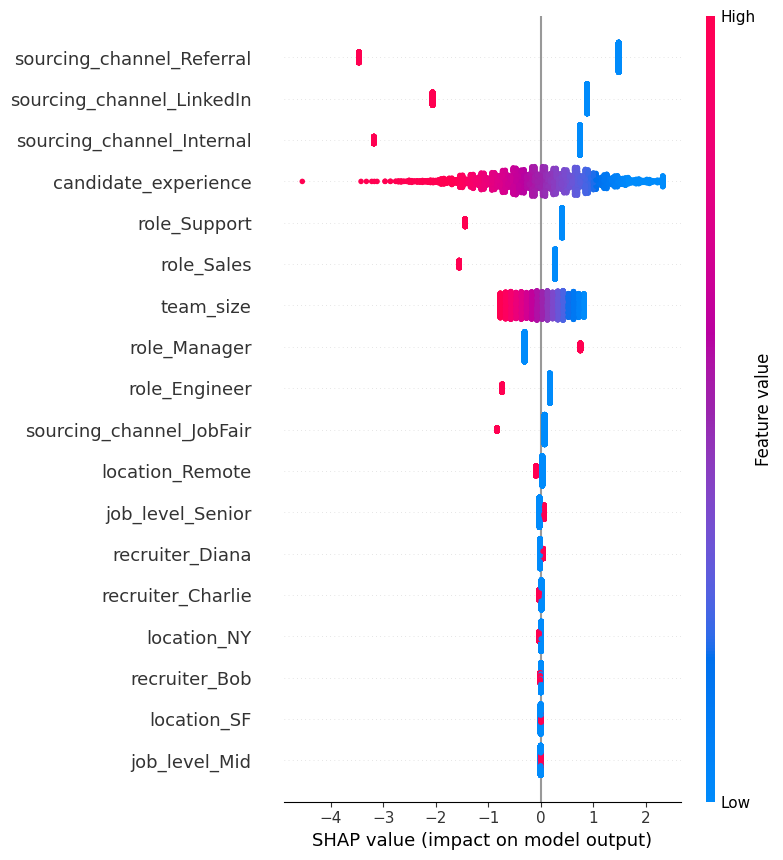

In [33]:
import shap

explainer = shap.Explainer(lr, X_train_scaled)
shap_values = explainer(X_train_scaled)

# Summary plot
shap.summary_plot(shap_values, features=X_train_scaled, feature_names=all_features)

Lasso Regression (for Feature Selection)

In [35]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train_time)

pd.Series(lasso.coef_, index=all_features).sort_values(ascending=False)

,0
role_Manager,0.428060
job_level_Senior,0.033798
recruiter_Diana,0.023189
location_SF,0.001777
recruiter_Bob,-0.000000
job_level_Mid,-0.000000
location_NY,-0.005570
recruiter_Charlie,-0.010604
location_Remote,-0.041333
sourcing_channel_JobFair,-0.239211


Lasso regression adds an L1 penalty to the linear model, which can:

Shrink small/less important coefficients closer to zero.

Eliminate some features entirely (coefficient becomes exactly 0) if they don't contribute much.


**Reccomendations**

Focus on Referrals, Internal sourcing, and LinkedIn to consistently reduce cost.

Re-evaluate expensive sourcing for Manager or Senior roles.

Deprioritize or automate roles with lower hiring cost impact (e.g., Support, Sales).

Pay less attention to recruiters or locations with coefficients close to 0 (they contribute little to variation).